Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.
Epoch 1/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 357s 2s/step - accuracy: 0.4427 - loss: 1.2161 - val_accuracy: 0.5325 - val_loss: 1.0081
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.7616 - loss: 0.5816 - val_accuracy: 0.6200 - val_loss: 0.6836
Epoch 3/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 341s 2s/step - accuracy: 0.8916 - loss: 0.2796 - val_accuracy: 0.5000 - val_loss: 2.3647
Epoch 4/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9276 - loss: 0.1902 - val_accuracy: 0.5625 - val_loss: 2.0848
Epoch 5/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.9589 - loss: 0.1189 - val_accuracy: 0.7683 - val_loss: 0.5933
Epoch 6/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.9720 - loss: 0.0779 - val_accuracy: 0.5625 - val_loss: 1.3888
Epoch 7/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9764 - loss: 0.0698 - val_accurac

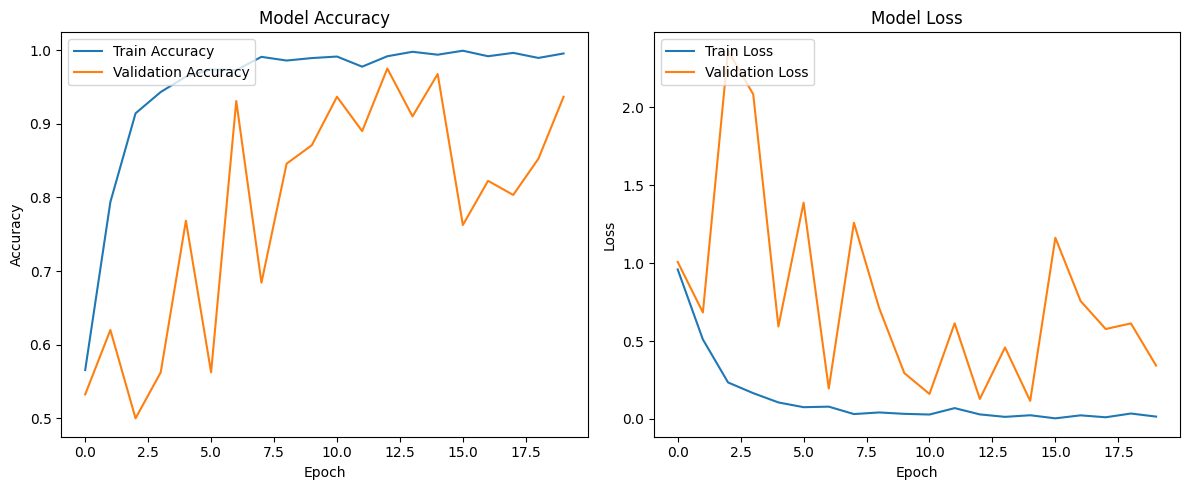

38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 604ms/step
Accuracy Score on Test Set: 0.76


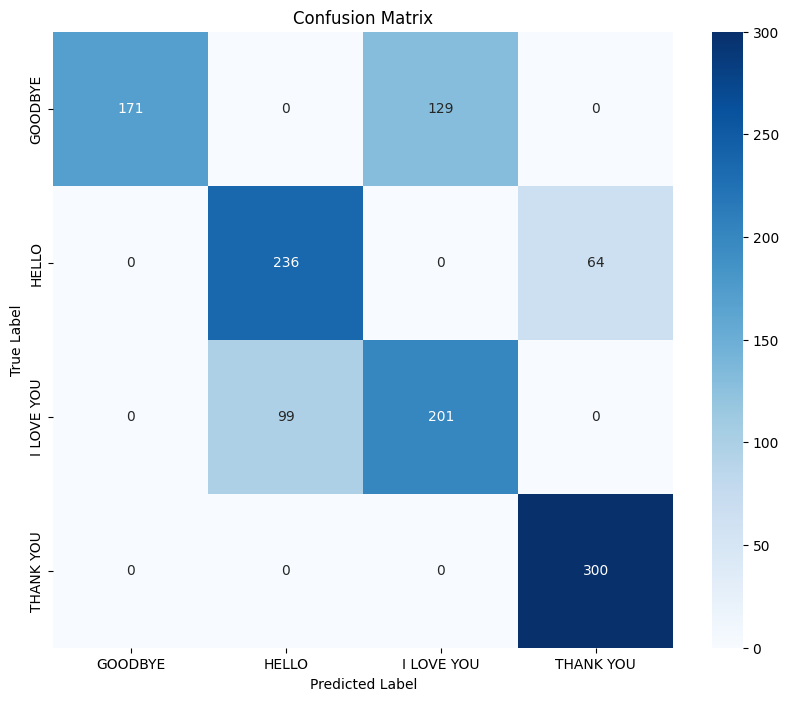

Classification Report:
               precision    recall  f1-score   support

     GOODBYE       1.00      0.57      0.73       300
       HELLO       0.70      0.79      0.74       300
  I LOVE YOU       0.61      0.67      0.64       300
   THANK YOU       0.82      1.00      0.90       300

    accuracy                           0.76      1200
   macro avg       0.78      0.76      0.75      1200
weighted avg       0.78      0.76      0.75      1200



In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")


# Define directories for the dataset
train_dir = '/kaggle/input/hg/Dataset/train'
val_dir = '/kaggle/input/hg/Dataset/validation'
test_dir = '/kaggle/input/hg/Dataset/test'

# Set parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create the model
def create_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(img_height, img_width, 3)),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Initialize model and compile
num_classes = len(train_generator.class_indices)
model = create_model(num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot training & validation accuracy values and save
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('/kaggle/working/training_plots.png')  
plt.show()

# Generate predictions for the test set
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
test_labels = test_generator.classes  

# Calculate and print accuracy score
accuracy = accuracy_score(test_labels, predicted_classes)
print(f'Accuracy Score on Test Set: {accuracy:.2f}')

# Save Confusion Matrix plot
conf_matrix = confusion_matrix(test_labels, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('/kaggle/working/confusion_matrix.png')  # Save the confusion matrix
plt.show()

# Save Classification Report to a text file
class_report = classification_report(test_labels, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", class_report)
with open('/kaggle/working/classification_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(class_report)